# Comparison of CMIP6 and CESM models with ERA5 data for Mackenzie River Basin
**Description:** Compares data from CMIP6 and CESM models with ERA5 for the Mackenzie River Basin  
**Creator:** Emma Perkins  
**Date:** June 2022

In [1]:
# Import relevant Packages
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import itertools
import scipy.stats as stats
from math import sqrt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

### Load in Full Data

In [2]:
# cesm full data
cesm_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/TREFHT/'  # TREFHT = reference height temp (2-meter air temp)
cesm_file1 = cesm_path+'b.e11.B1850C5CN.f09_g16.005.cam.h1.TREFHT.19000101-19991231.nc'
cesm_file2 = cesm_path+'b.e11.B1850C5CN.f09_g16.005.cam.h1.TREFHT.20000101-20991231.nc'
cesm_files = [cesm_file1, cesm_file2]
with xr.open_mfdataset(cesm_files, concat_dim=None) as cesm_full:
    print(cesm_full)

# cmip6 data (need to combine miultiple datasets in order to get same timeframe as single cesm dataset, 1900-2014)
cmip6_path = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER.006/atm/proc/tseries/day_1/'
cmip6_files19 = sorted(glob.glob(cmip6_path+'b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER.006.cam.h1.TREFHT.19*.nc'))
cmip6_files20 = sorted(glob.glob(cmip6_path+'b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER.006.cam.h1.TREFHT.20*.nc'))
cmip6_files_long = list(itertools.chain(cmip6_files19, cmip6_files20))
cmip6_files = cmip6_files_long[5:]  # ERA5 data starts in 1950, remove files from list for 1900-1949

with xr.open_mfdataset(cmip6_files, concat_dim=None) as cmip6_full:
    print(cmip6_full)

<xarray.Dataset>
Dimensions:       (lev: 30, time: 73000, ilev: 31, lat: 192, lon: 288, slat: 191, slon: 288, nbnd: 2)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 1900-01-02 00:00:00 ... 2100-01-01 00:00:00
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * slat          (slat) float64 -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
Dimensions without coordinates: nbnd
Data variables: (12/32)
    hyam          (time, lev) float64 dask.array<chunksize=(36500, 30), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(36500, 30), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(36500, 31), meta=np.n

In [3]:
# ERA5 data (need to combine 2 datasets)
era5_path = '/glade/work/eperkins/ERA5_data/'
era5_file1 = era5_path+'ERA5_hourly_temp_1950_1978.nc'
era5_file2 = era5_path+'ERA5_hourly_temp_1979_2014.nc'
era5_files = [era5_file1, era5_file2]

with xr.open_dataset(era5_file1) as era5_data1:
    print(era5_data1)
with xr.open_dataset(era5_file2) as era5_data2:
    print(era5_data2)

era5_data2 = era5_data2.drop_isel(time=np.arange(0, 24, 1))
era5_data = xr.merge([era5_data1, era5_data2])
print(era5_data)

<xarray.Dataset>
Dimensions:    (longitude: 153, latitude: 89, time: 42368)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -102.5 -102.2 -102.0
  * latitude   (latitude) float32 72.0 71.75 71.5 71.25 ... 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1950-01-01 ... 1978-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-16 00:18:40 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 153, latitude: 89, time: 52596)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -102.5 -102.2 -102.0
  * latitude   (latitude) float32 72.0 71.75 71.5 71.25 ... 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2014-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-15 20:37:40 GMT by grib_to_netcdf-2.24.3:

### Select Data for Dates of Interest

In [4]:
cesm_start = np.where(cesm_full.time == cmip6_full.time[0])[0][0]  # finding indices for start and end dates of cmip6 data in cesm data
print(cesm_start)

cesm_end = np.where(cesm_full.time == cmip6_full.time[-1])[0][0]
print(cesm_end)

18249
41974


In [5]:
cesm_sel = cesm_full.isel(time=np.arange(cesm_start, cesm_end, 1))  # downselecting cesm data to match cmip6 dates
print(cesm_sel.time[0])  # we can see that the data now line up with CMIP6
print(cesm_sel.time[-1])

cmip6_sel = cmip6_full.drop_isel(time=np.arange(len(cmip6_full.time)-1, len(cmip6_full.time), 1))
print(cmip6_sel.time[0])
print(cmip6_sel.time[-1])

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1950-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 2014-12-31 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1950-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 2014-12-31 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds


In [6]:
# create universal time index -- era5 and cesm/cmip6 have different calendars
time_index = cesm_sel.indexes['time'].to_datetimeindex()

# adding new time index to all datasets
cesm_sel['time'] = time_index
cmip6_sel['time'] = time_index

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [7]:
era5_daily = era5_data.resample(time='1D').mean('time')  # average era5 data by day

In [8]:
print(len(era5_daily.time))
print(len(cesm_sel.time))
print(len(cmip6_sel.time))  # need to get rid of leap days for era5 data

23741
23725
23725


In [9]:
# reshaping era5 data to get rid of leap days
era5_sel = np.zeros([len(era5_daily.latitude), len(era5_daily.longitude), len(cesm_sel.time)])

for i in range(0, len(cesm_sel.time)):
    era5_sel[:, :, i] = era5_daily.sel(time=cesm_sel.time[i]).to_array()

In [10]:
# convert back to xarray DataArray
lat_coord = era5_daily.latitude.to_numpy()
lon_coord = era5_daily.longitude.to_numpy()
time_coord = time_index

era5_sel_array = xr.DataArray(era5_sel, coords={'lat': lat_coord,
                                'lon': lon_coord, 'time': time_index}, dims=['lat','lon','time'],
                                 name='era5_T')

### Select Data for Area of Interest - Mackenzie River Basin

In [11]:
# convert cesm and cmip6 from long3 to long1
cesm_lon_new = (cesm_sel.lon + 180) % 360 - 180
cesm_sel['lon'] = cesm_lon_new
cesm_sel = cesm_sel.sortby('lon')
cmip6_lon_new = (cmip6_sel.lon + 180) % 360 - 180
cmip6_sel['lon'] = cmip6_lon_new
cmip6_sel = cmip6_sel.sortby('lon')

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
 

In [12]:
cesm_sel = cesm_sel.sel(lat=slice(50, 72), lon=slice(-140, -102))
print(cesm_sel)

cmip6_sel = cmip6_sel.sel(lat=slice(50,72), lon=slice(-140, -102))
print(cmip6_sel)

<xarray.Dataset>
Dimensions:       (lev: 30, time: 23725, ilev: 31, lat: 23, lon: 31, slat: 191, slon: 288, nbnd: 2)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
  * lat           (lat) float64 50.42 51.36 52.3 53.25 ... 69.27 70.21 71.15
  * lon           (lon) float64 -140.0 -138.8 -137.5 ... -105.0 -103.8 -102.5
  * slat          (slat) float64 -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
Dimensions without coordinates: nbnd
Data variables: (12/32)
    hyam          (time, lev) float64 dask.array<chunksize=(18251, 30), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(18251, 30), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(18251, 31), meta=np.ndarr

### Extract Temperature

In [13]:
cesm_temp = cesm_sel.TREFHT
print(cesm_temp)

cmip6_temp = cmip6_sel.TREFHT
print(cmip6_temp)

<xarray.DataArray 'TREFHT' (time: 23725, lat: 23, lon: 31)>
dask.array<getitem, shape=(23725, 23, 31), dtype=float32, chunksize=(18251, 23, 31), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
  * lat      (lat) float64 50.42 51.36 52.3 53.25 ... 68.32 69.27 70.21 71.15
  * lon      (lon) float64 -140.0 -138.8 -137.5 -136.2 ... -105.0 -103.8 -102.5
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean
<xarray.DataArray 'TREFHT' (time: 23725, lat: 23, lon: 31)>
dask.array<getitem, shape=(23725, 23, 31), dtype=float32, chunksize=(3650, 23, 31), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 50.42 51.36 52.3 53.25 ... 68.32 69.27 70.21 71.15
  * lon      (lon) float64 -140.0 -138.8 -137.5 -136.2 ... -105.0 -103.8 -102.5
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
Attributes:
    units:         K
    long_name:     Reference he

### Match lat lon coords for ERA5 with CESM and CMIP6

knn = NearestNeighbors(n_neighbors=5)
knn.fit(cesm_temp)
knn.kneighbors(

In [14]:
# reshaping era5 data to match dimensions of CESM and CMIP6 data
era5_reshape = np.zeros([len(cesm_temp.lat), len(cesm_temp.lon), len(cesm_temp.time)])

for i in range(0, len(cesm_temp.lat)):
    for j in range(0, len(cesm_temp.lon)):
        era5_reshape[i, j, :] = era5_sel_array.sel(lat=cesm_temp.lat[i],
                                                   lon=cesm_temp.lon[j], method='nearest')
# now has same dimensions but is numpy array instead of xr DataArray

In [15]:
# convert back to xarray DataArray
lat_coord = cesm_temp.lat.to_numpy()
lon_coord = cesm_temp.lon.to_numpy()
time_coord = time_index

era5_temp_analysis = xr.DataArray(era5_reshape, coords={'lat': lat_coord,
                                'lon': lon_coord, 'time': time_index}, dims=['lat','lon','time'],
                                 name='ERA5_T') 

In [16]:
# rename DataArrays and combine into one array, temp_data
cesm_temp = cesm_temp.rename('CESM_T')
cmip6_temp = cmip6_temp.rename('CMIP6_T')

temp_data = xr.merge([cesm_temp, cmip6_temp, era5_temp_analysis])  # combine all temp data into one data array
print(temp_data)

<xarray.Dataset>
Dimensions:  (time: 23725, lat: 23, lon: 31)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
  * lat      (lat) float64 50.42 51.36 52.3 53.25 ... 68.32 69.27 70.21 71.15
  * lon      (lon) float64 -140.0 -138.8 -137.5 -136.2 ... -105.0 -103.8 -102.5
Data variables:
    CESM_T   (time, lat, lon) float32 dask.array<chunksize=(18251, 23, 31), meta=np.ndarray>
    CMIP6_T  (time, lat, lon) float32 dask.array<chunksize=(3650, 23, 31), meta=np.ndarray>
    ERA5_T   (lat, lon, time) float64 277.1 277.9 280.4 ... 247.7 248.3 249.5
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean


### Compare ERA5 to CESM

In [17]:
cesm_era5_dif = temp_data.CESM_T - temp_data.ERA5_T
print(cesm_era5_dif)

<xarray.DataArray (time: 23725, lat: 23, lon: 31)>
dask.array<sub, shape=(23725, 23, 31), dtype=float64, chunksize=(18251, 23, 31), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
  * lat      (lat) float64 50.42 51.36 52.3 53.25 ... 68.32 69.27 70.21 71.15
  * lon      (lon) float64 -140.0 -138.8 -137.5 -136.2 ... -105.0 -103.8 -102.5


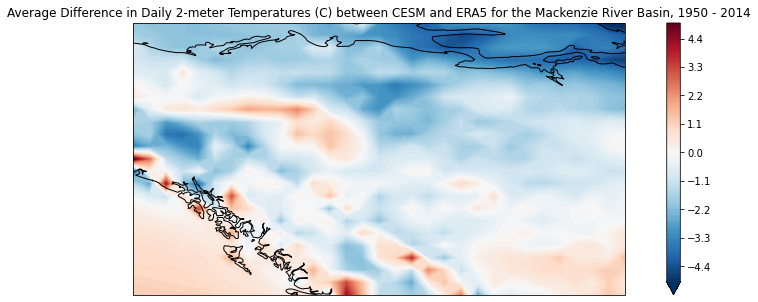

In [18]:
# plot daily temperature dif averaged over 1950-2014
cesm_era5_avg = cesm_era5_dif.mean(dim='time')

cmap1 = plt.cm.RdBu_r
lev1 = np.arange(-5, 5.05, 0.1)
fig1 = plt.figure(figsize=(15, 5))
ax1 = plt.axes(projection=ccrs.PlateCarree())
cesm_era5_avg.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=lev1,
                         cmap=cmap1, add_colorbar=True)
ax1.coastlines()
plt.title('Average Difference in Daily 2-meter Temperatures (C) between CESM and ERA5 for the Mackenzie River Basin, 1950 - 2014')
plt.savefig('MRBCesmERA5Map.png')
plt.show()

In [19]:
%%time

# difference between CESM and ERA5  -- long step ~15 mins
cesm_era5_mean = float(cesm_era5_dif.mean())
cesm_era5_stdev = float(cesm_era5_dif.std())
print('Mean: %f' % cesm_era5_mean)
print('Standard Deviation: %f' % cesm_era5_stdev)
print('Max Difference: %f' % np.amax(cesm_era5_dif))
print('Min Difference: %f' % np.amin(cesm_era5_dif))

Mean: -0.959666
Standard Deviation: 8.773758
Max Difference: 48.659424
Min Difference: -59.825378
CPU times: user 7min 59s, sys: 2min 20s, total: 10min 20s
Wall time: 11min 13s


These look like large differences but standard deviation is also very high -- look at statistical tests to determine if different than zero

In [20]:
n = len(cesm_era5_dif.lon) * len(cesm_era5_dif.lat) * len(cesm_era5_dif.time)
print(n)

16915925


In [21]:
test_stat = (cesm_era5_mean - 0)/(cesm_era5_stdev/np.sqrt(n))  # testing against null hypothesis that difference is 0
print(test_stat)  # seems very high

p_val = stats.t.sf(abs(test_stat), n-1)
print(p_val)

-449.86512759379576
0.0


p val of zero -- difference is statistically different than 0 -- cesm is statistically different than era5

In [ ]:
full_mse = float(np.square(np.subtract(obs_data_analysis,clim_data_analysis)).mean())
full_rmse = np.sqrt(mse)

print('Mean Squared Error: %f' % full_mse)
print('Root Mean Squared Error; %f' % full_rmse)

In [ ]:
cesm_era5_dif.plot.hist(bins=10000, color='b')
plt.title('Distribution of 2-meter Temperature Differences between CESM and ERA5')

In [ ]:
# Hypothesis test to see if difference is different from zero
single_ttest_result = stats.ttest_1samp(a=cesm_era5_avg, popmean=0)
print(single_ttest_result)  # seems to create separate test statistic for each longitude??

### Repeat for CMIP6

In [18]:
cmip6_era5_dif = temp_data.CMIP6_T - temp_data.ERA5_T
print(cmip6_era5_dif)

<xarray.DataArray (time: 23725, lat: 23, lon: 31)>
dask.array<sub, shape=(23725, 23, 31), dtype=float64, chunksize=(3650, 23, 31), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
  * lat      (lat) float64 50.42 51.36 52.3 53.25 ... 68.32 69.27 70.21 71.15
  * lon      (lon) float64 -140.0 -138.8 -137.5 -136.2 ... -105.0 -103.8 -102.5


In [ ]:
# plot daily temperature dif averaged over 1950-2014
cmip6_era5_avg = cmip6_era5_dif.mean(dim='time')

cmap1 = plt.cm.RdBu_r
lev1 = np.arange(-5, 5.05, 0.1)
fig1 = plt.figure(figsize=(15, 5))
ax1 = plt.axes(projection=ccrs.PlateCarree())
cmip6_era5_avg.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=lev1,
                         cmap=cmap1, add_colorbar=True)
ax1.coastlines()
plt.title('Average Difference in Daily 2-meter Temperatures (C) between CMIP6 and ERA5 for the Mackenzie River Basin, 1950 - 2014')
plt.savefig('MRBCmipERA5Map.png')
plt.show()

In [ ]:
# difference between CMIP6 and ERA5  -- long step
cmip_mean = float(cmip6_era5_dif.mean())
cmip_stdev = float(cmip6_era5_dif.std())
print('Mean: %f' % cmip_mean)
print('Standard Deviation: %f' % cmip_stdev)
print('Max Difference: %f' % np.amax(cmip6_era5_dif))
print('Min Difference: %f' % np.amin(cmip6_era5_dif))

In [ ]:
cmip6_era5_dif.plot.hist(bins=10000, color='b')
plt.title('Distribution of 2-meter Temperature Differences Between CMIP6 and ERA5')

In [ ]:
# perform single sample ttest 'by hand'
test_stat = (cmip_mean - 0)/(cmip_stdev/sqrt(n))
print(test_stat)  # seems very high

p_val = stats.t.sf(abs(test_stat), n-1)
print(p_val)

p-val of 0 --> cmip6 data is statistically different than era5 for 2-meter temp

### Compare CMIP6 with CESM

In [ ]:
cesm_cmip6_dif = temp_data.CESM_T - temp_data.CMIP6_T
cesm_cmip6_dif_avg = cesm_cmip6_dif.mean(dim='time')

cmap1 = plt.cm.RdBu_r
lev1 = np.arange(-5, 5.05, 0.1)
fig1 = plt.figure(figsize=(15, 5))
ax1 = plt.axes(projection=ccrs.PlateCarree())
cesm_cmip6_dif_avg.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=lev1,
                         cmap=cmap1, add_colorbar=True)
ax1.coastlines()

In [ ]:
# difference between CMIP6 and ERA5  -- long step
clim_mean = float(cesm_cmip6_dif.mean())
clim_stdev = float(cesm_cmip6_dif.std())
print('Mean: %f' % clim_mean)
print('Standard Deviation: %f' % clim_stdev)
print('Max Difference: %f' % np.amax(cesm_cmip6_dif))
print('Min Difference: %f' % np.amin(cesm_cmip6_dif))

In [ ]:
cesm_cmip6_dif.plot.hist(bins=10000, color='b')
plt.title('Distribution of differences between CESM and CMIP6 Errors')

In [ ]:
fig1 = plt.figure(figsize=(9, 5))
plot1 = cmip6_era5_dif.plot.hist(bins=10000, color='r', alpha=0.5, label='CMIP6 - ERA5')
plot2 = cesm_era5_dif.plot.hist(bins=10000, color='k', alpha=0.5, label='CESM - ERA5')
plt.legend()
plt.title('Differences Between Climate Models and Observations for the Mackenzie River Basin, 1950-2014')
plt.xlabel('Temperature Difference (degrees C)')
plt.ylabel('Count')
plt.savefig('MRBClimModDif.png')
plt.show()

In [ ]:
# Hypothesis test to see if difference is different from zero
single_ttest_result = stats.ttest_1samp(a=cesm_cmip6_dif_avg, popmean=0)
print(single_ttest_result)  # seems to create separate test statistic for each longitude??

In [ ]:
# perform single sample ttest 'by hand'
test_stat = (clim_mean - 0)/(clim_stdev/sqrt(n))
print(test_stat)  # seems very large

p_val = stats.t.sf(abs(test_stat), n-1)
print(p_val)

### Plot distribution of actual temperatures for CESM vs ERA5 and CMIP6 vs ERA5

In [19]:
cesm_tempc = temp_data.CESM_T - 273.15  # convert from degrees K to degrees C
cmip6_tempc = temp_data.CMIP6_T - 273.15
era5_tempc = temp_data.ERA5_T - 273.15

In [ ]:
fig1 = plt.figure(figsize=(9, 5))
plot1 = cesm_tempc.plot.hist(bins=10000, color='r', alpha=0.5, label='CESM Temperatures')
plot2 = era5_tempc.plot.hist(bins=10000, color='k', alpha=0.5, label='ERA5 Temperatures')
plt.legend()
plt.title('Distribution of 2-meter Temperatures from CESM and ERA5 for the Mackenzie River Basin, 1950-2014')
plt.xlabel('Temperature (degrees C)')
plt.ylabel('Count')
plt.xlim(-70, 30)
plt.ylim(0,8000)
plt.savefig('MRBCesmERA5.png')
plt.show()

In [ ]:
fig1 = plt.figure(figsize=(9, 5))
plot1 = cmip6_tempc.plot.hist(bins=10000, color='r', alpha=0.5, label='CMIP6 Temperatures')
plot2 = era5_tempc.plot.hist(bins=10000, color='k', alpha=0.5, label='ERA5 Temperatures')
plt.legend()
plt.title('Distribution of 2-meter Temperatures from CMIP6 and ERA5 for the Mackenzie River Basin, 1950-2014')
plt.xlabel('Temperature (degrees C)')
plt.ylabel('Count')
plt.xlim(-70, 30)
plt.ylim(0,8000)
plt.savefig('MRBCmipERA5.png')
plt.show()

### Mask Out Oceans

In [20]:
# Grid
ds_grid = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc')
mask = ds_grid.mask

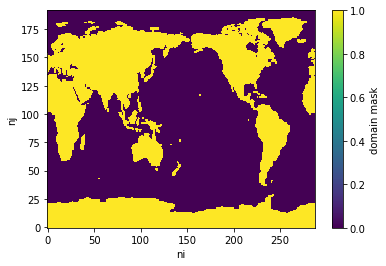

In [21]:
mask.plot()

In [22]:
# rename mask coordinates
mask = mask.rename({'xc': 'lon', 'yc': 'lat'})  # xc (lon, ni) - 288, yc (lat, nj) - 192
print(mask)

<xarray.DataArray 'mask' (nj: 192, ni: 288)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
    lon      (nj, ni) float64 ...
    lat      (nj, ni) float64 ...
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  domain mask
    note:       unitless
    comment:    0 value indicates cell is not active


In [23]:
# convet mask lon coordinates to long1
new_lon = (mask.lon.sel(nj=0) + 180) % 360 - 180

for j in range(0, len(mask.nj)):
    mask.lon[j,:] = new_lon

In [24]:
# match mask coordinates to data coordinates
mask_new = np.zeros([len(cesm_tempc.lat), len(cesm_tempc.lon)])

for i in range(0, len(cesm_tempc.lat)):
    for j in range(0, len(cesm_tempc.lon)):
        lat_dif = mask.lat[:, 0] - cesm_tempc.lat[i]
        lat_index = np.where(np.abs(lat_dif) == np.amin(np.abs((mask.lat[:, 0]) - cesm_tempc.lat[i])))[0][0]
        lon_index = np.where(mask.lon == cesm_tempc.lon[j])[1][0]
        mask_new[i,j] = mask.sel(ni=lon_index).sel(nj=lat_index)

In [25]:
# convert back to xarray DataArray
lat_coord = cesm_tempc.lat.to_numpy()
lon_coord = cesm_tempc.lon.to_numpy()

mask_new= xr.DataArray(mask_new, coords={'lat': lat_coord,
                                'lon': lon_coord}, dims=['lat','lon'],
                                 name='mask') 

In [26]:
# turn ocean mask zeros into NaNs so they dont factor into statistical calculations
zero_lats = np.where(mask_new == 0)[0]
zero_lons = np.where(mask_new == 0)[1]
one_lats = np.where(mask_new != 0)[0]
one_lons = np.where(mask_new != 0)[1]

ocean_mask = np.zeros([len(cesm_tempc.lat), len(cesm_tempc.lon)])
land_mask = np.zeros([len(cesm_tempc.lat), len(cesm_tempc.lon)])

# create mask where oceans are NaN and Land is 1
for i in range(0, len(zero_lats)):
    ocean_mask[zero_lats[i], zero_lons[i]] = np.NaN
for j in range(0, len(one_lats)):
    ocean_mask[one_lats[j], one_lons[j]] = 1

# create mask where land is NaN and Ocean in 1
for i in range(0, len(zero_lats)):
    land_mask[zero_lats[i], zero_lons[i]] = 1
for j in range(0, len(one_lats)):
    land_mask[one_lats[j], one_lons[j]] = np.NaN

In [27]:
cesm_land = cesm_tempc*ocean_mask
cesm_ocean = cesm_tempc*land_mask
cmip6_land = cmip6_tempc*ocean_mask
cmip6_ocean = cmip6_tempc*land_mask

In [33]:
era5_land = np.zeros([len(era5_tempc.lat), len(era5_tempc.lon), len(era5_tempc.time)])
era5_ocean = np.zeros([len(era5_tempc.lat), len(era5_tempc.lon), len(era5_tempc.time)])

for i in range(0, len(era5_tempc.time)):
    era5_land[:, :, i] = era5_tempc[:, :, i]*ocean_mask

for i in range(0, len(era5_tempc.time)):
    era5_ocean[:, :, i] = era5_tempc[:, :, i]*land_mask

In [34]:
# convert back to xarray DataArray
lat_coord = era5_tempc.lat.to_numpy()
lon_coord = era5_tempc.lon.to_numpy()
time_coord = era5_tempc.time

era5_land = xr.DataArray(era5_land, coords={'lat': lat_coord,
                                'lon': lon_coord, 'time': time_coord}, dims=['lat','lon', 'time'],
                                 name='era5_land')
era5_ocean = xr.DataArray(era5_ocean, coords={'lat': lat_coord,
                                'lon': lon_coord, 'time': time_coord}, dims=['lat','lon', 'time'],
                                 name='era5_ocean')

In [29]:
cesm_era5_dif_land = cesm_era5_dif*ocean_mask
land_dif_avg = cesm_era5_dif_land.mean(dim='time')

cesm_era5_dif_ocean = cesm_era5_dif*land_mask
ocean_dif_avg = cesm_era5_dif_ocean.mean(dim='time')

### Land Only Plots and Statistics

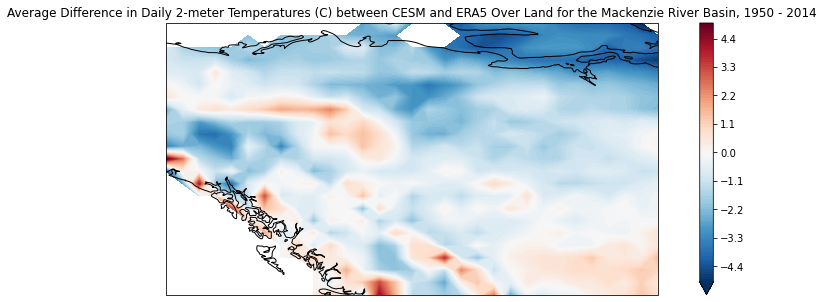

In [44]:
cmap1 = plt.cm.RdBu_r
lev1 = np.arange(-5, 5.05, 0.1)
fig1 = plt.figure(figsize=(15, 5))
ax1 = plt.axes(projection=ccrs.PlateCarree())
land_dif_avg.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=lev1,
                         cmap=cmap1, add_colorbar=True)
ax1.coastlines()
plt.title('Average Difference in Daily 2-meter Temperatures (C) between CESM and ERA5 Over Land for the Mackenzie River Basin, 1950 - 2014')
plt.savefig('MRBCesmERA5MapLand.png')
plt.show()

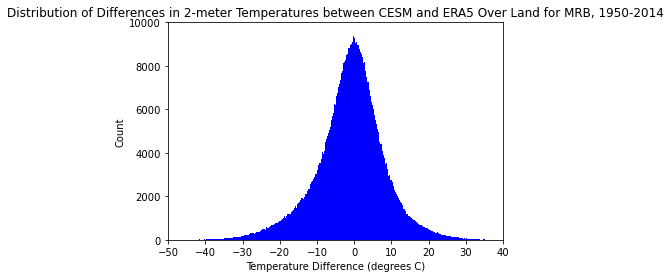

In [37]:
cesm_era5_dif_land.plot.hist(bins=10000, color='b')
plt.title('Distribution of Differences in 2-meter Temperatures between CESM and ERA5 Over Land for MRB, 1950-2014')
plt.xlabel('Temperature Difference (degrees C)')
plt.ylabel('Count')
plt.xlim(-50, 40)
plt.ylim(0,10000)
plt.savefig('MRBCesmERA5Land.png')
plt.show()

In [30]:
land_mean = cesm_era5_dif_land.mean()
land_stdev = cesm_era5_dif_land.std()
land_min = np.amin(cesm_era5_dif_land)
land_max = np.amax(cesm_era5_dif_land)
print('Mean Difference in 2-meter Temperatures Between CESM and ERA5 over land: %f' % land_mean)
print('Standard Deviation of Difference in 2-meter Temperatures Between CESM and ERA5 over land: %f' % land_stdev)
print('Minimum Difference in 2-meter Temperatures Between CESM and ERA5 over land: %f' % land_min)
print('Maximum Difference in 2-meter Temperatures Between CESM and ERA5 over land: %f' % land_max)

Mean Difference in 2-meter Temperatures Between CESM and ERA5 over land: -1.058061
Standard Deviation of Difference in 2-meter Temperatures Between CESM and ERA5 over land: 9.161089
Minimum Difference in 2-meter Temperatures Between CESM and ERA5 over land: -59.825378
Maximum Difference in 2-meter Temperatures Between CESM and ERA5 over land: 48.659424


In [31]:
# land t-test
land_n = len(np.where(ocean_mask == 1)[0])*len(np.where(ocean_mask == 1)[1])*len(cesm_era5_dif_land.time)

land_test_stat = (float(land_mean) - 0)/(float(land_stdev)/sqrt(land_n))
print(land_test_stat)

land_p_val = stats.t.sf(abs(land_test_stat), land_n-1)
print(land_p_val)

-11243.045833711474
0.0


p-val of zero --> difference in 2-meter temps between cesm and era5 is different from 0 over land

In [36]:
# land f-test
era5_land_var = float((era5_land.std())**2)
cesm_land_var = float((cesm_land.std())**2)

land_f_stat = era5_land_var/cesm_land_var
land_f_p_val = 1-stats.f.cdf(land_f_stat, land_n-1, land_n-1)

print(land_f_stat)
print(land_f_p_val)

0.7996778449088745
1.0


p-val of one --> variances of cesm and era5 data over land are not statistically different from each other

In [ ]:
land_mse = mean_squared_error(era5_land, cesm_land, squared=True)
land_rmse = mean_squared_error(era5_land, cesm_land, squared=False)
print('Mean Squared Error for Differences between ERA5 and CESM 2-meter Temperatures Over Land: %f' % land_mse)
print('Root Mean Squared Error for Differences between ERA5 and CESM 2-meter Temperatures Over Land: %f' % land_rmse)

### Ocean Only Plots and Statistics

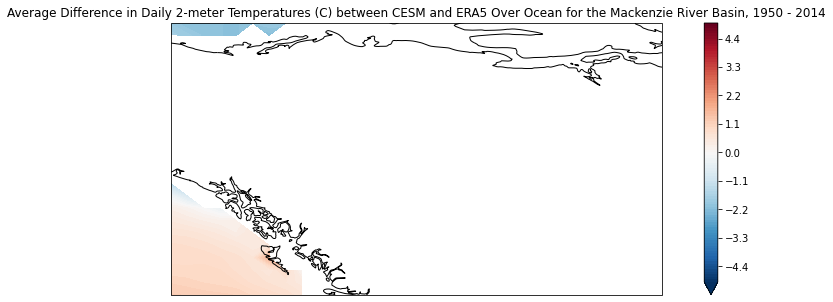

In [45]:
cmap1 = plt.cm.RdBu_r
lev1 = np.arange(-5, 5.05, 0.1)
fig1 = plt.figure(figsize=(15, 5))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ocean_dif_avg.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=lev1,
                         cmap=cmap1, add_colorbar=True)
ax1.coastlines()
plt.title('Average Difference in Daily 2-meter Temperatures (C) between CESM and ERA5 Over Ocean for the Mackenzie River Basin, 1950 - 2014')
plt.savefig('MRBCesmERA5MapOcean.png')
plt.show()

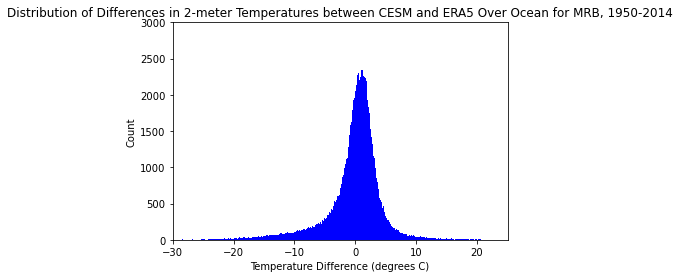

In [50]:
cesm_era5_dif_ocean.plot.hist(bins=10000, color='b')
plt.title('Distribution of Differences in 2-meter Temperatures between CESM and ERA5 Over Ocean for MRB, 1950-2014')
plt.xlabel('Temperature Difference (degrees C)')
plt.ylabel('Count')
plt.xlim(-30, 25)
plt.ylim(0, 2500)
plt.savefig('MRBCesmERA5Ocean.png')
plt.show()

In [47]:
ocean_mean = cesm_era5_dif_ocean.mean()
ocean_stdev = cesm_era5_dif_ocean.std()
ocean_min = np.amin(cesm_era5_dif_ocean)
ocean_max = np.amax(cesm_era5_dif_ocean)
print('Mean Difference in 2-meter Temperatures Between CESM and ERA5 over ocean: %f' % ocean_mean)
print('Standard Deviation of Difference in 2-meter Temperatures Between CESM and ERA5 over ocean: %f' % ocean_stdev)
print('Minimum Difference in 2-meter Temperatures Between CESM and ERA5 over ocean: %f' % ocean_min)
print('Maximum Difference in 2-meter Temperatures Between CESM and ERA5 over ocean: %f' % ocean_max)

Mean Difference in 2-meter Temperatures Between CESM and ERA5 over ocean: -0.191939
Standard Deviation of Difference in 2-meter Temperatures Between CESM and ERA5 over ocean: 4.702373
Minimum Difference in 2-meter Temperatures Between CESM and ERA5 over ocean: -44.217468
Maximum Difference in 2-meter Temperatures Between CESM and ERA5 over ocean: 28.891083


In [51]:
# ocean t-test
ocean_n = len(np.where(land_mask == 1)[0])*len(np.where(land_mask == 1)[1])*len(cesm_era5_dif_ocean.time)

ocean_test_stat = (float(ocean_mean) - 0)/(float(ocean_stdev)/sqrt(ocean_n))
print(ocean_test_stat)

ocean_p_val = stats.t.sf(abs(ocean_test_stat), ocean_n-1)
print(ocean_p_val)

-509.25250001148544
0.0


p-val of zero --> difference in 2-meter temps between cesm and era5 is different from 0 over ocean

In [74]:
# ocean f test
era5_ocean_var = float((era5_ocean.std())**2)
cesm_ocean_var = float((cesm_ocean.std())**2)

ocean_f_stat = era5_ocean_var/cesm_ocean_var
ocean_f_p_val = 1-stats.f.cdf(ocean_f_stat, ocean_n-1, ocean_n-1)

print(ocean_f_stat)
print(ocean_f_p_val)

0.7432989342858161
1.0


In [ ]:
ocean_mse = mean_squared_error(era5_ocean, cesm_ocean, squared=True)
ocean_rmse = mean_squared_error(era5_ocean, cesm_ocean, squared=False)
print('Mean Squared Error for Differences between ERA5 and CESM 2-meter Temperatures Over Ocean: %f' % ocean_mse)
print('Root Mean Squared Error for Differences between ERA5 and CESM 2-meter Temperatures Over Ocean: %f' % ocean_rmse)

p-val of one --> variances in cesm data and era5 data over ocean are not statistically different

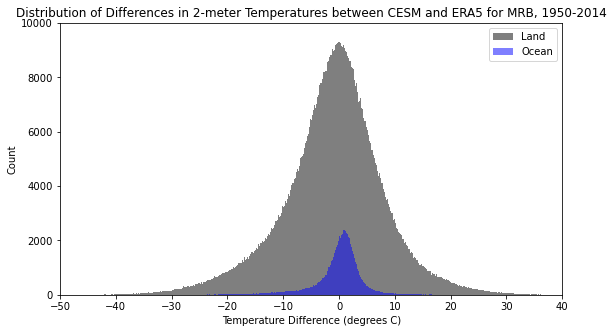

In [52]:
fig1 = plt.figure(figsize=(9, 5))
cesm_era5_dif_land.plot.hist(bins=10000, color='k', alpha=0.5, label='Land')
cesm_era5_dif_ocean.plot.hist(bins=10000, color='b', alpha=0.5, label='Ocean')
plt.axvline(x = 0, color = 'r', label = 'Zero')
plt.legend()
plt.title('Distribution of Differences in 2-meter Temperatures between CESM and ERA5 for MRB, 1950-2014')
plt.xlabel('Temperature Difference (degrees C)')
plt.ylabel('Count')
plt.xlim(-50, 40)
plt.ylim(0, 10000)
plt.savefig('MRBCesmERA5LandOceanCompare.png')
plt.show()

### Compare Models with ERA5 for Each Month of the Year

In [63]:
# extracting data for January
jan = np.where(temp_data.CESM_T['time'].dt.month == 1)[0]
cesm_jan = temp_data.CESM_T.isel(time=jan) - 273.15
cmip_jan = temp_data.CMIP6_T.isel(time=jan) - 273.15
era5_jan = temp_data.era5_T.isel(time=jan) - 273.15

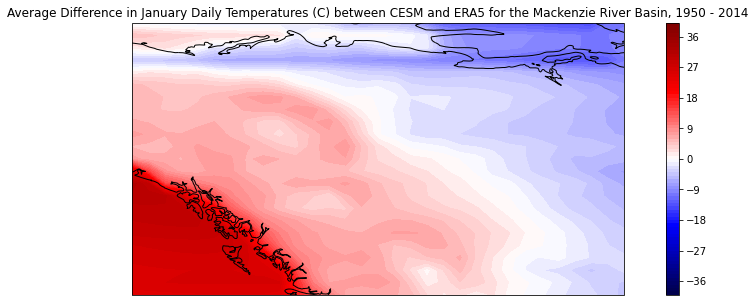

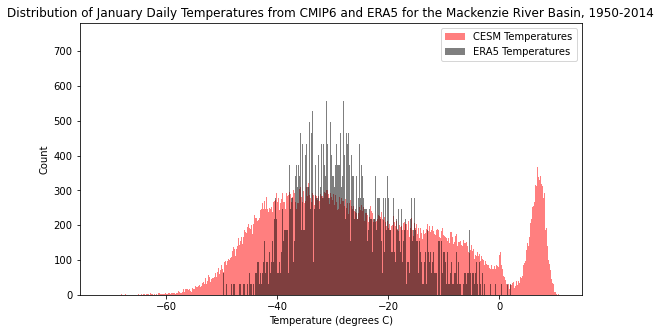

In [64]:
# Plotting differences for January

# cesm - era5
jan_cesm_era5 = cesm_jan - era5_jan
jan_cesm_era5_avg = jan_cesm_era5.mean(dim='time')

cmap1 = plt.cm.seismic
lev1 = np.arange(-40, 40.1, 1)
fig1 = plt.figure(figsize=(15, 5))
ax1 = plt.axes(projection=ccrs.PlateCarree())
jan_cesm_era5_avg.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=lev1,
                         cmap=cmap1, add_colorbar=True)
ax1.coastlines()
plt.title('Average Difference in January Daily Temperatures (C) between CESM and ERA5 for the Mackenzie River Basin, 1950 - 2014')
plt.savefig('MRBCesmERA5Map_Jan.png')
plt.show()

fig1 = plt.figure(figsize=(9, 5))
plot1 = cesm_jan.plot.hist(bins=10000, color='r', alpha=0.5, label='CESM Temperatures')
plot2 = era5_jan.plot.hist(bins=10000, color='k', alpha=0.5, label='ERA5 Temperatures')
plt.legend()
plt.title('Distribution of January Daily Temperatures from CESM and ERA5 for the Mackenzie River Basin, 1950-2014')
plt.xlabel('Temperature (degrees C)')
plt.ylabel('Count')
plt.savefig('MRBCesmERA5_Jan.png')
plt.show()

In [68]:
# extracting data for February
feb = np.where(temp_data.CESM_T['time'].dt.month == 2)[0]
cesm_feb = temp_data.CESM_T.isel(time=feb) - 273.15
cmip_feb = temp_data.CMIP6_T.isel(time=feb) - 273.15
era5_feb = temp_data.era5_T.isel(time=feb) - 273.15

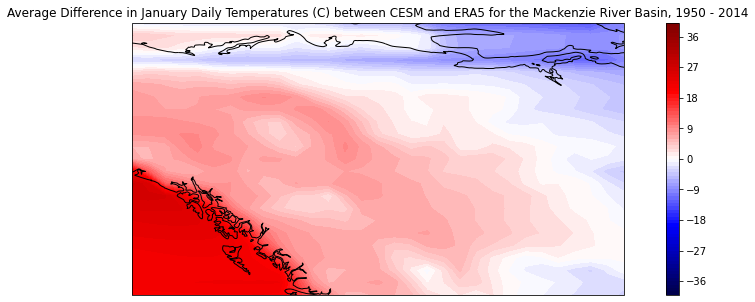

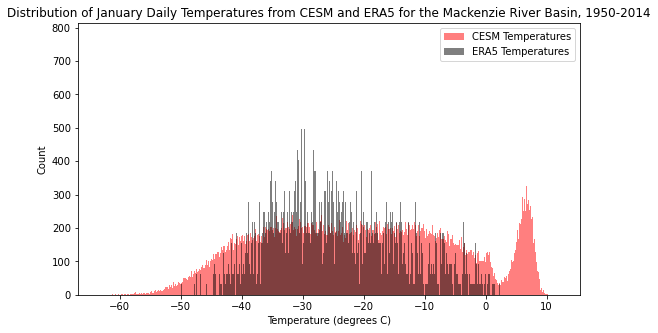

In [69]:
# Plotting differences for February

# cesm - era5
feb_cesm_era5 = cesm_feb - era5_feb
feb_cesm_era5_avg = feb_cesm_era5.mean(dim='time')

cmap1 = plt.cm.seismic
lev1 = np.arange(-40, 40.1, 1)
fig1 = plt.figure(figsize=(15, 5))
ax1 = plt.axes(projection=ccrs.PlateCarree())
feb_cesm_era5_avg.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=lev1,
                         cmap=cmap1, add_colorbar=True)
ax1.coastlines()
plt.title('Average Difference in February Daily Temperatures (C) between CESM and ERA5 for the Mackenzie River Basin, 1950 - 2014')
plt.savefig('MRBCesmERA5Map_Feb.png')
plt.show()

fig1 = plt.figure(figsize=(9, 5))
plot1 = cesm_feb.plot.hist(bins=10000, color='r', alpha=0.5, label='CESM Temperatures')
plot2 = era5_feb.plot.hist(bins=10000, color='k', alpha=0.5, label='ERA5 Temperatures')
plt.legend()
plt.title('Distribution of February Daily Temperatures from CESM and ERA5 for the Mackenzie River Basin, 1950-2014')
plt.xlabel('Temperature (degrees C)')
plt.ylabel('Count')
plt.savefig('MRBCesmERA5_Feb.png')
plt.show()